<a href="https://colab.research.google.com/github/sambethune/causal_learning/blob/master/06_3_%3E13_3_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the DataBlock API

## Data Processing

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

from fastai.vision import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This week we will be using Chris Crawford's *Cat* dataset (available from Kaggle) to investigate the workings of the DataBlock API. Given Colab boots with the Kaggle download package preinstalled, we are able to immediately begin downloading the dataset. Here we make use of the *%* operator rather than the more conventional *!* as it leverages a higher level of permission.

In [0]:
% cd /root

/root


In [0]:
% mkdir .kaggle

In [0]:
% cd .kaggle

/root/.kaggle


In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sambethune","key":"49115b5c7fae82a77ba05bff05567c40"}'}

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/06 3->13 3

/content/drive/My Drive/SCIE3250 Journal/06 3->13 3


In [0]:
! kaggle datasets download -d crawford/cat-dataset

100% 4.02G/4.04G [01:25<00:00, 21.4MB/s]
100% 4.04G/4.04G [01:25<00:00, 50.4MB/s]


In [0]:
! unzip cat-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/CAT_05/00001130_020.jpg.cat  
  inflating: cats/CAT_05/00001130_023.jpg  
  inflating: cats/CAT_05/00001130_023.jpg.cat  
  inflating: cats/CAT_05/00001130_026.jpg  
  inflating: cats/CAT_05/00001130_026.jpg.cat  
  inflating: cats/CAT_05/00001131_003.jpg  
  inflating: cats/CAT_05/00001131_003.jpg.cat  
  inflating: cats/CAT_05/00001131_026.jpg  
  inflating: cats/CAT_05/00001131_026.jpg.cat  
  inflating: cats/CAT_05/00001132_007.jpg  
  inflating: cats/CAT_05/00001132_007.jpg.cat  
  inflating: cats/CAT_05/00001132_008.jpg  
  inflating: cats/CAT_05/00001132_008.jpg.cat  
  inflating: cats/CAT_05/00001132_014.jpg  
  inflating: cats/CAT_05/00001132_014.jpg.cat  
  inflating: cats/CAT_05/00001132_017.jpg  
  inflating: cats/CAT_05/00001132_017.jpg.cat  
  inflating: cats/CAT_05/00001132_018.jpg  
  inflating: cats/CAT_05/00001132_018.jpg.cat  
  inflating: cats/CAT_05/00001132_021.jpg  
  inflating: cats/CAT_05/0000

In [0]:
! rm cat-dataset.zip

Given the considerable scale of our dataset, we will here restrict ourselves to just a fraction of what is available (~1/6 of the data).

In [2]:
% cd /content/drive/My Drive/SCIE3250 Journal/06 3->13 3/CAT_00

path = Path('.')

/content/drive/My Drive/SCIE3250 Journal/06 3->13 3/CAT_00


Let's take a look at one of our images, along with its label, to get an idea of what we have downloaded.

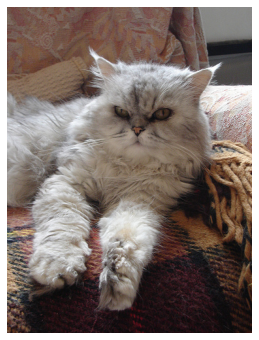

In [3]:
my_fname = '00000001_000.jpg'
my_fpath = Path('00000001_000.jpg')

img = open_image(path/my_fname)
img.show(figsize=(6, 6))

In [0]:
df = pd.read_csv('00000001_000.jpg.cat')
df.head()

,9 175 160 239 162 199 199 149 121 137 78 166 93 281 101 312 96 296 133


Intending to compile our data as a databunch using the datablock API, we now create some functions to format and filter our data appropriately. We also throw in one to visualize the labels of a given image.

In [0]:
def fpath_2_lname(func):
  """
  Decorator to convert file path input from datablock API to label name.

  Args:
    func (call): Function, the argument of which we will change from a filepath
    to a label name.

  Returns:
    func(lname) (arb): Output of function with label name corresponding to 
    filepath as input.
  """
  def inner(fpath):
    lname = str(fpath) + '.cat'

    return func(lname)

  return inner


@fpath_2_lname
def get_pixtensor(fpath):
  pix_array = np.genfromtxt(fpath, dtype=np.float32)

  return torch.tensor(pix_array[1:]).reshape(-1, 2)


@fpath_2_lname
def filter_img(fpath):
  return int(np.genfromtxt(fpath)[0]) == 9


def show_labelled_img(fpath):
  img = open_image(str(fpath))
  pts = get_pixtensor(fpath)
  ip = ImagePoints(FlowField(img.size, pts), scale=True)

  img.show(y=ip, figsize=(6, 6))

In [0]:
get_pixtensor(my_fname)

tensor([[175., 160.],
        [239., 162.],
        [199., 199.],
        [149., 121.],
        [137.,  78.],
        [166.,  93.],
        [281., 101.],
        [312.,  96.],
        [296., 133.]])

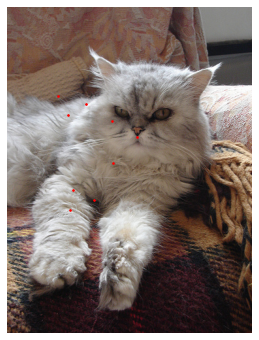

In [0]:
show_labelled_img(my_fname)

Oh no; it appears our label has been rotated counter clockwise by $\pi/2$. Suspecting that the *x* and *y* pixels have mistakenly been swapped, we sample another image to investigate further.

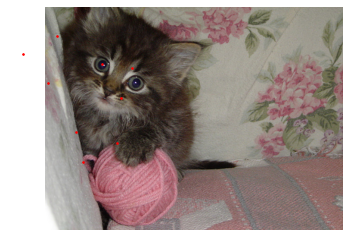

In [5]:
your_fname = '00000001_005.jpg'

show_labelled_img(your_fname)

Our suspicions seem to have been well placed; we remedy the situation as below by flipping our pixel tensor.

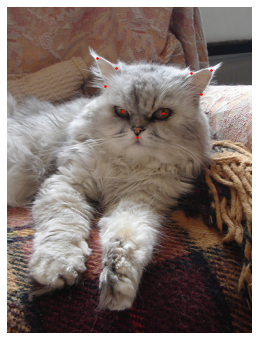

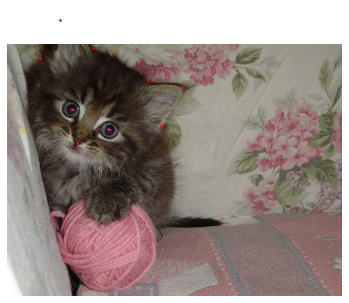

In [6]:
@fpath_2_lname
def get_pixtensor(fpath):
  pix_array = np.genfromtxt(fpath, dtype=np.float32)

  return torch.tensor(pix_array[1:]).reshape(-1, 2).flip(1)


show_labelled_img(my_fname)
show_labelled_img(your_fname)

We are now able to compile our databunch.

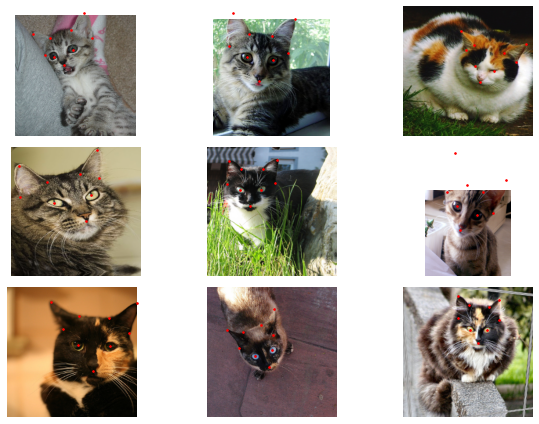

In [7]:
data = (
        PointsItemList.from_folder(path, extensions=['.jpg'])
        .filter_by_func(filter_img)
        .split_by_rand_pct()
        .label_from_func(get_pixtensor)
        .transform(get_transforms(do_flip=False), tfm_y=True, size=224, 
          remove_out=False)
        .databunch().normalize(imagenet_stats)
       )

data.show_batch(3, figsize=(9,6))

With our data ready to train on, we begin learning.


## Initial Training

Initially we consider a ResNet34 architecture, intending to upgrade to ResNet50 once we have a better handle on things.

In [0]:
learn = cnn_learner(data, models.resnet34)
learn.save('prelim')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time
0,4.284738,#na#,04:30
1,4.220485,#na#,00:33
2,3.774320,#na#,00:34
3,3.361952,#na#,00:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


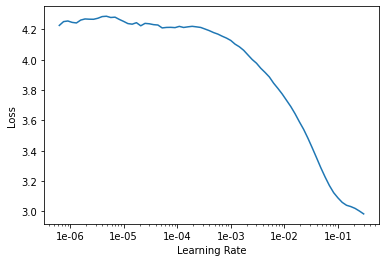

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,time
0,2.425952,0.964274,01:46
1,1.506639,0.287797,00:38
2,0.894398,0.111230,00:38
3,0.567378,0.057836,00:38
4,0.372135,0.044676,00:38
5,0.253930,0.036319,00:39
6,0.178693,0.033082,00:39
7,0.130068,0.026814,00:39
8,0.096764,0.026096,00:41
9,0.075345,0.025215,00:40


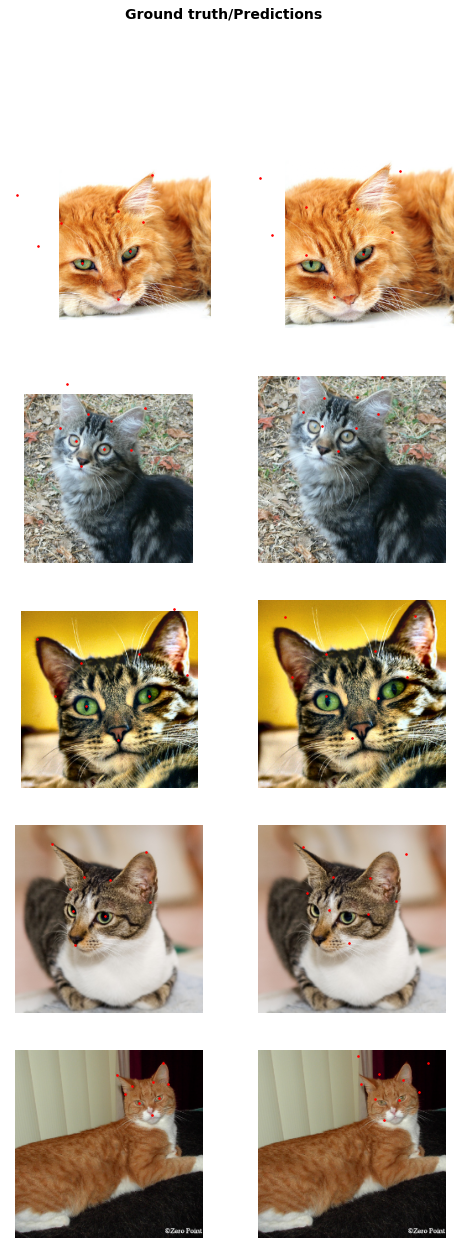

In [0]:
learn.save('stage-1')
learn.show_results()

While we seem to be identifying the relevant regions of interest in our images with a high level of success, our model is unsure of the details. We will move onto a ResNet50 architecture, which we will also fine tune.

## Final Model

In [0]:
train = cnn_learner(data, models.resnet50)
train.save('prelim')

epoch,train_loss,valid_loss,time
0,4.334341,#na#,04:25
1,4.274639,#na#,00:38
2,3.894418,#na#,00:34
3,4.014025,#na#,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


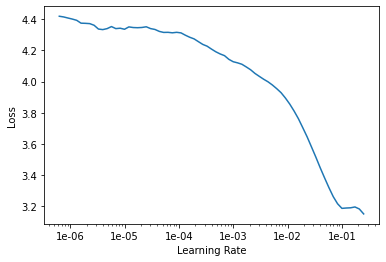

In [0]:
train.lr_find()
train.recorder.plot()

In [9]:
train.fit_one_cycle(10, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,time
0,2.685335,1.472710,00:44
1,1.604594,0.312306,00:43
2,0.966056,0.088470,00:43
3,0.606357,0.057150,00:43
4,0.396536,0.040437,00:43
5,0.268424,0.038540,00:42
6,0.187818,0.031747,00:42
7,0.137412,0.027266,00:42
8,0.101084,0.024871,00:42
9,0.077808,0.024146,00:42


In [0]:
train.save('stage-1')

epoch,train_loss,valid_loss,time
0,0.032782,#na#,00:36
1,0.034266,#na#,00:34
2,0.057861,#na#,00:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


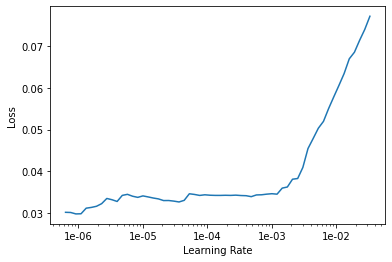

In [11]:
train.unfreeze()
train.lr_find()
train.recorder.plot()

In [12]:
train.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,time
0,0.061241,0.074444,00:41
1,0.074451,0.483145,00:41
2,0.081425,0.958882,00:40
3,0.084570,0.118893,00:41
4,0.081535,0.049894,00:40
5,0.074884,0.052399,00:41
6,0.069946,0.036271,00:40
7,0.062816,0.033458,00:40
8,0.059072,0.024302,00:41
9,0.053192,0.023933,00:41


Unfortunately things don't seem to have worked out; our learning rate is too high. We'll try reducing it over a greater number of epochs.

In [14]:
train.load('stage-1')
train.unfreeze()

train.fit_one_cycle(50, 1e-5)

epoch,train_loss,valid_loss,time
0,0.035249,0.024150,00:43
1,0.032186,0.023896,00:42
2,0.032724,0.023287,00:42
3,0.032957,0.023209,00:41
4,0.032929,0.022716,00:41
5,0.033605,0.022089,00:41
6,0.033475,0.021531,00:41
7,0.031627,0.020984,00:41
8,0.031280,0.020496,00:41
9,0.029469,0.020501,00:41


In [0]:
train.save('stage-2')

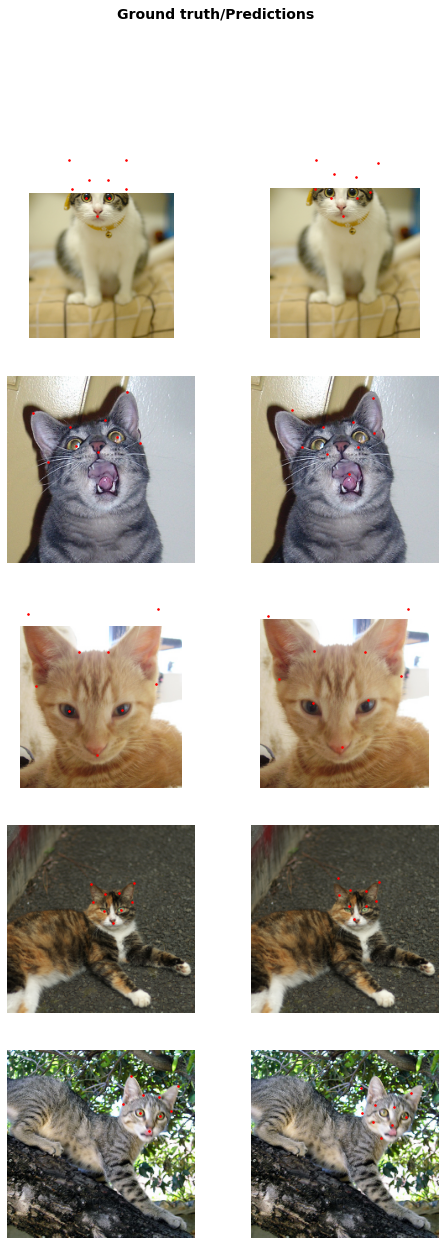

In [21]:
train.show_results()

While we have improved greatly, we could go further still were we able to use the whole data set on a sufficient accelerator.